# Time Series Forecasting with Prophet

## 📦 Overview

This notebook applies Facebook Prophet to the classic AirPassengers dataset and walks through model configuration, forecast, and diagnostics.

---

## 📂 Load Data

In [1]:
from modules import utils
utils.configure_plotly_template(showlegend=True)

import pandas as pd

path = '../../../data/statsmodels/AirPassengers.parquet'
df = pd.read_parquet(path).asfreq('ME')
df.columns = ['y']
df['ds'] = df.index
df = df[['ds', 'y']]
df

,ds,y
1949-01-31,1949-01-31,112
1949-02-28,1949-02-28,118
...,...,...
1960-11-30,1960-11-30,390
1960-12-31,1960-12-31,432


---

## 🔧 Model Fit

In [2]:
from prophet import Prophet

model = Prophet(
    seasonality_mode="multiplicative",
    changepoint_range=1.0,  # use full history
    n_changepoints=30,  # more flexibility in trend
)

model.fit(df)

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:16:48 - cmdstanpy - INFO - Chain [1] start processing
09:16:48 - cmdstanpy - INFO - Chain [1] done processing


---

## 📈 Forecast

In [3]:
future = model.make_future_dataframe(periods=48, freq='M')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
187,1964-08-31,827.215030,805.080311,854.242529
188,1964-09-30,705.416880,683.474064,730.185743
...,...,...,...,...
190,1964-11-30,541.109761,522.248393,561.453890
191,1964-12-31,600.479301,579.907170,622.267288


---

## 🖼️ Plot Forecast

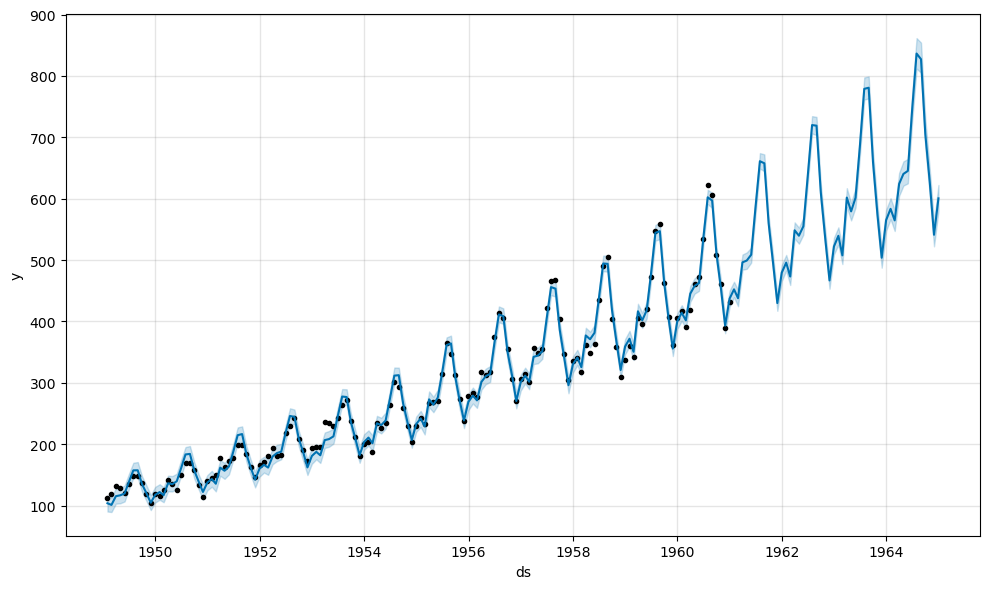

In [4]:
model.plot(forecast);

---

## ⚙️ Prophet Configuration

1. Prophet automatically detects trend and seasonality using changepoints.
2. You configure:

   * **Trend flexibility** (with or without change points)
   * **Additive vs. multiplicative** seasonality (`seasonality_mode`)
   * **Custom seasonalities** (optional)
   * **Holiday effects** (optional)

---

### 📌 Rule of Thumb

> “Prophet config is semi-automatic: trend and seasonal components are learned with flexible change points. You choose seasonal mode and horizon — minimal tuning required.”

---

## 🧪 Seasonal Decomposition (For Visual Insight Only)

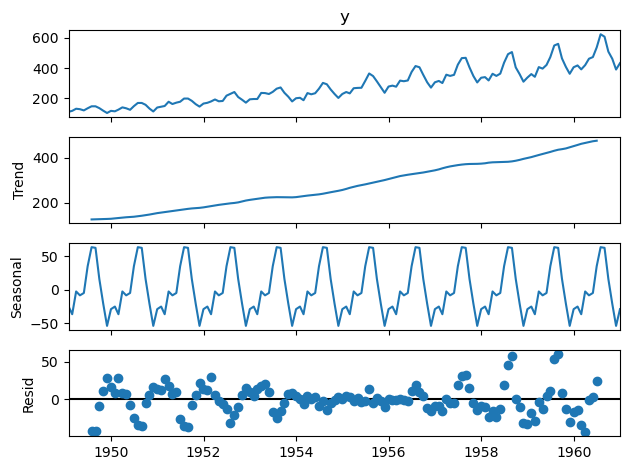

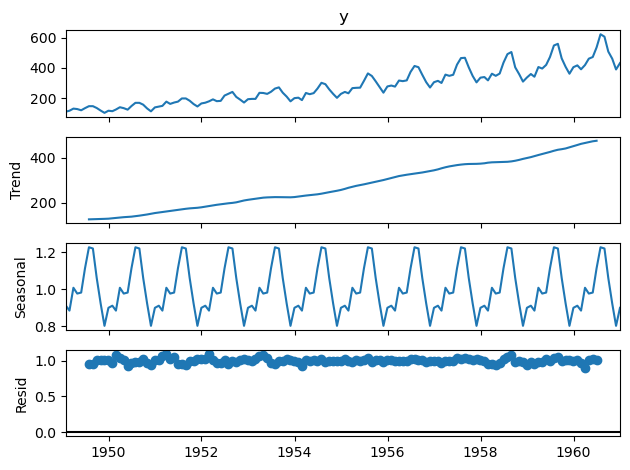

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['y'], model="additive", period=12).plot();
seasonal_decompose(df['y'], model="multiplicative", period=12).plot();

---

## 🎛️ Variation Playground

In [6]:
from prophet import Prophet

def fit_prophet(df, mode="multiplicative"):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        seasonality_mode=mode
    )
    m.fit(df)
    future = m.make_future_dataframe(periods=48, freq='M')
    fc = m.predict(future)
    return fc[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': f"forecast_{mode}"})

df_add = fit_prophet(df, mode="additive")
df_mul = fit_prophet(df, mode="multiplicative")

combined = df.set_index('ds').join(df_add).join(df_mul)
combined.plot()

09:16:49 - cmdstanpy - INFO - Chain [1] start processing
09:16:49 - cmdstanpy - INFO - Chain [1] done processing
/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
09:16:49 - cmdstanpy - INFO - Chain [1] start processing
09:16:49 - cmdstanpy - INFO - Chain [1] done processing
/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


---

## 🔍 Diagnostics and Assumptions

Although Prophet is robust and doesn’t require stationarity or normal residuals, residual analysis helps confirm quality.

---

### 📉 Residual Calculation

In [7]:
df_forecast = forecast.set_index("ds")[['yhat']].join(df.set_index("ds"))
df_forecast['residuals'] = df_forecast['y'] - df_forecast['yhat']
residuals = df_forecast['residuals'].dropna()

---

### 🔁 Autocorrelation

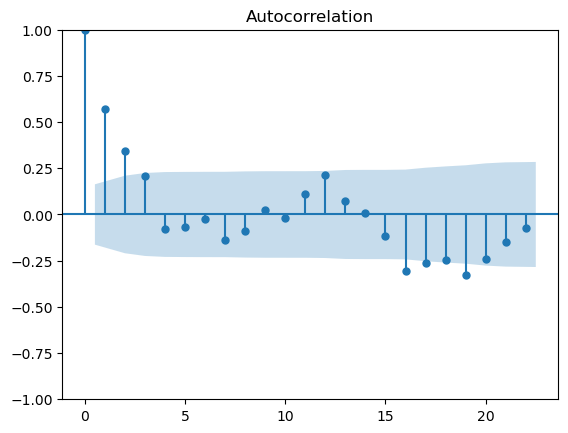

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

---

### 🧪 Ljung-Box Test

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,78.129313,0.000000
20,154.912672,0.000000
30,204.339979,0.000000


---

### 📊 Normality Check

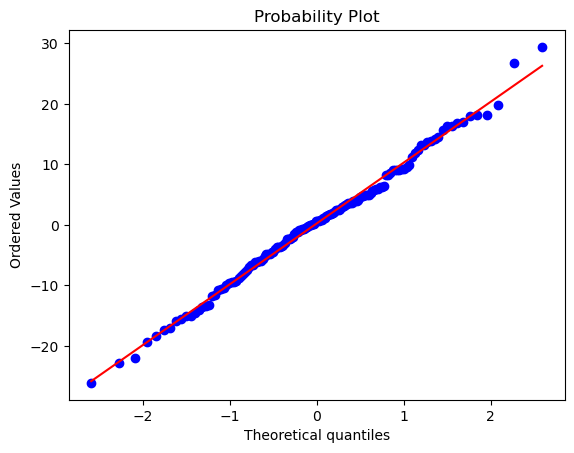

In [10]:
from scipy import stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

---

### 📈 Jarque-Bera Test

In [11]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(0.1647689985804243), pvalue=np.float64(0.9209177983736971))

---

### 🪟 Homoscedasticity (Constant Variance)

In [12]:
residuals.plot()

from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(17.969850358046912),
 np.float64(0.0554743577296043),
 1.9049286766071647,
 0.05049430025169186)

---

## ✅ Final Takeaway

> “Prophet provides quick and flexible forecasts. Diagnostics help validate performance — even if residuals aren’t perfect, low autocorrelation and reasonable error distribution often indicate a usable model.”